In [1]:
# %%
import sys
import os
import math
from pathlib import Path

sys.path.insert(0,os.getcwd()+"/..")
from dataset.WeatherBenchData import WeatherBenchData

from torch.utils.data import DataLoader,BatchSampler,SequentialSampler,RandomSampler
import torch
import torch.nn.functional as F
from torch.nn import KLDivLoss, MSELoss
import torch.nn as nn


from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from diffusers import UNet3DConditionModel, UNet2DModel, AutoencoderKL, VQModel,UNet2DConditionModel
from diffusers.models.embeddings import TimestepEmbedding 
from diffusers.models.unet_2d_condition import UNet2DConditionOutput


# Imports for discriminator model 
from taming.modules.discriminator.model import NLayerDiscriminator, weights_init
from taming.modules.losses.vqperceptual import hinge_d_loss, vanilla_d_loss

from collections import namedtuple

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tqdm
import re

from ldm.models.diffusion.ddpm_weather import DDPM
from ldm.models.diffusion.ddim import DDIMSampler

from ldm.modules.diffusionmodules.openaimodel import UNetModel
import properscoring as ps

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from datetime import datetime
from ldm.modules.diffusionmodules.util import make_ddim_sampling_parameters, make_ddim_timesteps, noise_like

/home/sarkar/anaconda3/envs/weather/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %%
base_path = "/home/sarkar/Documents/WeatherBench_12/"

train_data = WeatherBenchData(Path(base_path),"train",subset=2015,transforms=None)
test_data = WeatherBenchData(Path(base_path),"test",transforms=None)
val_data = WeatherBenchData(Path(base_path),"val",transforms=None)

print(len(train_data),len(test_data))

# %%
batch_size = 64
train_dataloader = DataLoader(train_data, sampler=BatchSampler(
        SequentialSampler(train_data), batch_size=batch_size, drop_last=False
    ))

test_dataloader = DataLoader(test_data, sampler=BatchSampler(
        SequentialSampler(test_data), batch_size=batch_size, drop_last=False
    ))
val_dataloader = DataLoader(val_data, sampler=BatchSampler(
        SequentialSampler(val_data), batch_size=batch_size, drop_last=False
    ))

Total no of channels: 14
<xarray.Dataset>
Dimensions:  (lat: 32, level: 13, lon: 64, time: 350633)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 1979-01-01T07:00:00 ... 2018-12-31T23:00:00
Data variables: (12/14)
    v        (time, level, lat, lon) float32 dask.array<chunksize=(5, 13, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(5, 32, 64), meta=np.ndarray>
    v10      (time, lat, lon) float32 dask.array<chunksize=(5, 32, 64), meta=np.ndarray>
    u        (time, level, lat, lon) float32 dask.array<chunksize=(5, 13, 32, 64), meta=np.ndarray>
    t        (time, level, lat, lon) float32 dask.array<chunksize=(5, 13, 32, 64), meta=np.ndarray>
    vo       (time, level, lat, lon) float32 dask.array<chunksize=(5, 13, 

In [3]:
# Change model and model weights
from model.temb import DDPM
diffusion = DDPM( 
    cond_model_pth="../outputs/checkpoints/ch_110/v3/vqgan_v3_110ch_ep100.pth",
    #first_stage_model_pth="../outputs/checkpoints/ch_1/v6/vqgan_v6_1ch_ep200.pth"
    first_stage_model_pth="../outputs/checkpoints/ch_1/v11/vqgan_v11_1ch_best_ep99.pth"
)
f = "../checkpoints/new_diffusion_temb_v2.pth"
diffusion.load_state_dict(torch.load(f)["state_dict"])
diffusion = diffusion.to("cuda")

In [4]:
import torch
from diffusers import DiffusionPipeline,HeunDiscreteScheduler, DDIMScheduler,UniPCMultistepScheduler,DPMSolverMultistepScheduler


class MyPipeline(DiffusionPipeline):
    def __init__(self, model, scheduler):
        super().__init__()

        self.register_modules(model=model, scheduler=scheduler)

    @torch.no_grad()
    def __call__(self,day,hour, cond, shape, batch_size: int = 1, num_inference_steps: int = 50):
        # Sample gaussian noise to begin loop
        c,h,w = shape
        image = torch.randn((batch_size, c,h,w ))

        image = image.to(self.device)
        c = self.model.cond_stage_model.encode(cond).latents
        c = c.view(cond.size(0), 64, -1)
        cc = torch.broadcast_to(c, (batch_size, 64, 32*64))
        # set step values
        self.scheduler.set_timesteps(num_inference_steps)

        for t in self.progress_bar(self.scheduler.timesteps):
            # 1. predict noise model_output
            image = self.scheduler.scale_model_input(image,t)
            model_output = self.model(image,t,day,hour,cc)

            # 2. predict previous mean of image x_t-1 and add variance depending on eta
            # eta corresponds to η in paper and should be between [0, 1]
            # do x_t -> x_t-1
            image = self.scheduler.step(model_output, t, image).prev_sample

        #image = (image / 2 + 0.5).clamp(0, 1)
        #image = image.cpu().permute(0, 2, 3, 1).numpy()
        image = diffusion.first_stage_model.decode(image)
        return image
    
scheduler = DPMSolverMultistepScheduler(trained_betas=diffusion.betas.cpu(),use_karras_sigmas=True)
diffusion = diffusion.to("cuda")
pipe = MyPipeline(diffusion,scheduler)

/home/sarkar/anaconda3/envs/weather/lib/python3.10/site-packages/diffusers/schedulers/scheduling_dpmsolver_multistep.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.betas = torch.tensor(trained_betas, dtype=torch.float32)


In [5]:
no_ensemble_members = 50
ensemble_members = []
total_crps =0
s = 20

batch_size = 128*2
test_dataloader = DataLoader(test_data, sampler=BatchSampler(
        SequentialSampler(test_data), batch_size=batch_size, drop_last=False
    ))

for i, item in enumerate(test_dataloader):
    cond_,tgt_ = item

    hour = tgt_["hour"].squeeze(0)* 2 * math.pi / 24
    day = (tgt_["day"].squeeze(0) - 1 )* 2 * math.pi / 365

    tgt = tgt_["data"]
    cond = cond_["data"]
    tgt = tgt.reshape(tgt.shape[1], 1,  32,64)
    cond = cond.squeeze(0)
    
    cond = cond.to("cuda")
    day = day.to("cuda")
    hour = hour.to("cuda")
    members = []
    t1 = datetime.now()
    for i in range(no_ensemble_members):
        op = pipe(day,hour,cond,[4, 16, 32], num_inference_steps=s,batch_size=cond.shape[0])
        forecasts =  op[0][0].cpu().detach().numpy()
        members.append(forecasts)
    ensemble_members.append( np.stack(members))
    t2 = datetime.now()
    

print(t2-t1)
stacked_ensemble = np.hstack(ensemble_members)

  5%|▌         | 1/20 [00:01<00:25,  1.33s/it]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│   25 │   members = []                                                                            │
│   26 │   t1 = datetime.now()                                                                     │
│   27 │   for i in range(no_ensemble_members):                                                    │
│ ❱ 28 │   │   op = pipe(day,hour,cond,[4, 16, 32], num_inference_steps=s,batch_size=cond.shape    │
│   29 │   │   forecasts =  op[0][0].cpu().detach().numpy()                                        │
│   30 │   │   members.append(forecasts)                                                           │
│   31 │   ensemble_members.append( np.stack(members))                                             │
│                                                                                                  │
│ /home/sarkar/anaconda3/envs/weather/lib/python3.10/site-packages/torch/utils/_contextlib.py:115  │
│ in decorate_context                                                                              │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ in __call__                                                                                      │
│                                                                                                  │
│   24 │   │   for t in self.progress_bar(self.scheduler.timesteps):                               │
│   25 │   │   │   # 1. predict noise model_output                                                 │
│   26 │   │   │   image = self.scheduler.scale_model_input(image,t)                               │
│ ❱ 27 │   │   │   model_output = self.model(image,t,day,hour,cc)                                  │
│   28 │   │   │                                                                                   │
│   29 │   │   │   # 2. predict previous mean of image x_t-1 and add variance depending on eta     │
│   30 │   │   │   # eta corresponds to η in paper and should be between [0, 1]                    │
│                                                                                                  │
│ /home/sarkar/anaconda3/envs/weather/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 │
│ in _call_impl                                                                                    │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used    

In [19]:
stacked_ensemble = np.hstack(ensemble_members)
stacked_ensemble.shape

(5, 512, 1, 32, 64)

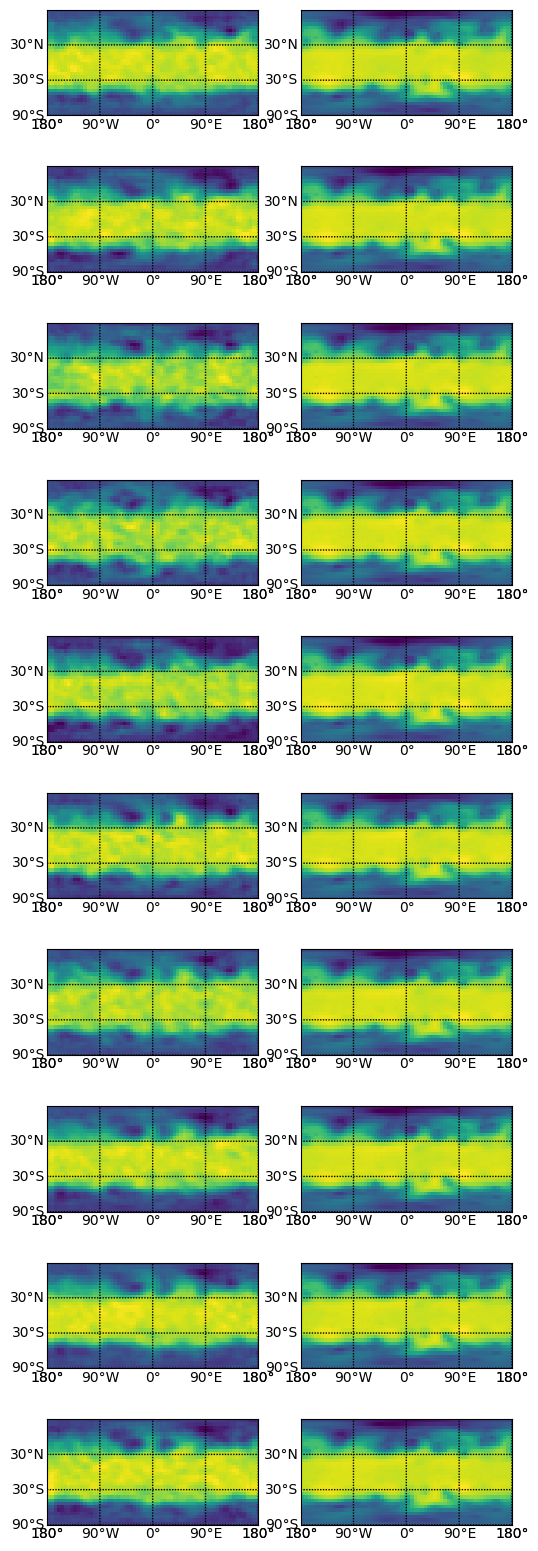

In [8]:
n = 10
j =0
fig, axs = plt.subplots(n, 2,figsize=(6,20))
for i in range(10,20):

    v_min = torch.min(op[0][0][i][0])
    v_max = torch.max(op[0][0][i][0])
    u_min = torch.min(tgt[i][0])
    u_max = torch.max(tgt[i][0])

    v_min = min(v_min,u_min)  
    v_max = max(v_max,u_max)  

    map = Basemap(ax = axs[j][0])
    # plot coastlines, draw label meridians and parallels.
    #map.drawcoastlines()
    map.drawparallels(np.arange(-90,90,60),labels=[1,0,0,0])
    map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,90),labels=[0,0,0,1])
    map.imshow(op[0][0][i][0].cpu().detach().numpy())

    map = Basemap(ax = axs[j][1])
    # plot coastlines, draw label meridians and parallels.
   # map.drawcoastlines()
    map.drawparallels(np.arange(-90,90,60),labels=[1,0,0,0])
    map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,90),labels=[0,0,0,1])
    map.imshow(cond[i+1][85].cpu().detach().numpy())
    j+=1

In [ ]:
total_crps = 0
total_rmse = 0
weights_lat = np.array([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437])
weights_lat = weights_lat[:, np.newaxis]
test_dataloader = DataLoader(test_data, sampler=BatchSampler(
        SequentialSampler(test_data), batch_size=1, drop_last=False
    ))
it = iter(test_dataloader)
for i in range(stacked_ensemble.shape[1] - 2):
    forecast = stacked_ensemble[:,i,:,:].squeeze() * 59563.01 + 77907.086
    cond_,tgt  = next(it)
    
    observations = tgt["data"].squeeze() * 59563.01 + 77907.086
    observations = observations.to("cpu")

    crps_score = ps.crps_ensemble(observations,forecast,axis=0)
    
    ensemble_mean = np.mean(forecast,axis = 0)
    rmse = np.sqrt(np.mean(  weights_lat * (ensemble_mean - observations.cpu().detach().numpy()) ** 2) )

    print(np.mean(weights_lat * crps_score),rmse)
    total_crps += np.mean(weights_lat * crps_score)
    total_rmse += rmse

print("RMSE", total_rmse/stacked_ensemble.shape[1])
print("CRPS", total_crps/stacked_ensemble.shape[1])
print("time for each sample ensemble",(t2-t1)/batch_size)